### Load sector data

##### r_average = (1 + r_cumulative)**1/n -1

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.width', 1000)  

# File IDs from the link
link_input = '1A9aTYrAWyEmIBHAw56XkM-H8ArF_kmuX'
download_url = f"https://drive.google.com/uc?id={link_input}"
input = pd.read_csv(download_url)

choose_from = ['Basic Materials', 'Energy', 'Financials', 'Industrials', 'Information Technology', 'Consumer Staples', 'Utilities', 'Healthcare', 'Consumer Discretionary']

# Convert the 'DateTime' column to datetime and set it as the index
input['DateTime'] = pd.to_datetime(input['DateTime'], format='%d.%m.%Y %H:%M')

# Calculate daily returns for U.S. Basic Materials
for sector in choose_from:
    input[f'U.S. {sector}'] = input[f'U.S. {sector}'].pct_change()

input = input.dropna()
#input

##### Calculate equally weighted portfolio of actual combined returns of all sectors

In [7]:
predictions_dict = {}

for sector in choose_from:
    predictions_dict[sector] =  pd.read_csv(f"predictions/{sector}_predictions.csv")

# Create a dataframe for the dates we are interested in
timeline_df = pd.to_datetime(predictions_dict['Basic Materials']['DateTime'])

actual_daily_returns = []

for i in range(len(timeline_df)):
    daily = 0
    
    for sector in choose_from:
        # Retrieve the daily returns of each sector
        sec_daily_return = predictions_dict[sector].iloc[i,2]
        daily += sec_daily_return

    actual_daily_returns.append(daily/len(choose_from))

actual_sectors_cumulative = []
cumulative_product = 1
for daily_return in actual_daily_returns:
    cumulative_product *= (1 + daily_return)
    actual_sectors_cumulative.append(cumulative_product - 1)

sharpe_ratio_actual = ((1 + actual_sectors_cumulative[-1]) ** (1/5.8) - 1 - 0.011) / (np.std(actual_daily_returns) * np.sqrt(252))

##### Minimum variance portfolio

##### The minimum variance portfolio is the solution to the following problem:

##### $$ \min w'\Sigma w,\quad w'1=1,~w\ge0$$

##### Let the solution be $w^*$. The variance of the minimum variance portfolio is $s_i=\sqrt{w^{*'} \Sigma w^* }$.

In [8]:
from scipy.optimize import minimize

daily_returns = []
was_out_of_market = True

# Go through all trading days
for i in range(len(timeline_df)-1):
    daily = 0
    number_bullish = 0
    sectors_bullish = ['DateTime']

    # This is the transaction cost incurred evry time we go in the market
    if was_out_of_market == True:
        daily = -0.001

    # Go through every sector for a given trading day
    for sector in choose_from:

        # If a sector is predicted bullish, include it in that day's portfolio
        cluster = predictions_dict[sector]['Predicted_Cluster'].iloc[i]
        if cluster == 1:
            number_bullish += 1
            sectors_bullish.append(f'U.S. {sector}')


    # Define the date range for filtering
    end_date = timeline_df.iloc[i]
    start_date = end_date - pd.DateOffset(months=1)

    # Select the relevant columns and filter rows by date range
    daily_df = input[sectors_bullish]
    daily_df = daily_df[(daily_df['DateTime'] >= start_date) & (daily_df['DateTime'] <= end_date)]
    returns_df = daily_df.drop(columns='DateTime')

    if returns_df.empty:
        daily_returns.append(0.011/365)
        was_out_of_market = True

    elif len(sectors_bullish) <=3:
        daily_returns.append(0.011/365)
        was_out_of_market = True

    else:
        was_out_of_market = False
        
        # Calculate covariance matrix
        cov_matrix = returns_df.cov().values
        
        # Number of assets
        num_assets = len(sectors_bullish) - 1  # Excluding 'DateTime'
        
        # Define the objective function (portfolio variance)
        def portfolio_variance(weights):
            return np.dot(weights.T, np.dot(cov_matrix, weights))
        
        # Constraints: weights sum to 1
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        
        # Bounds for weights: (0,1) for each asset
        bounds = tuple((0, 1) for _ in range(num_assets))
        
        # Initial guess (equal weights)
        initial_guess = np.array([1 / num_assets] * num_assets)
        
        # Optimize
        result = minimize(portfolio_variance, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        
        # Get the optimized weights and store them
        weights = result.x

        next_day = input[input['DateTime'] > end_date].iloc[0]        
        next_day = next_day[[col for col in sectors_bullish if col != 'DateTime']]

        daily += np.dot(weights, next_day)
        daily_returns.append(daily)


minvar_sectors_cumulative = [0]
cumulative_product = 1
for daily_return in daily_returns:
    cumulative_product *= (1 + daily_return)
    minvar_sectors_cumulative.append(cumulative_product - 1)

sharpe_ratio_minvar = ((1 + minvar_sectors_cumulative[-1]) ** (1/5.8) - 1 - 0.011) / (np.std(daily_returns) * np.sqrt(252))

##### Equally weighted portfolio

In [9]:
daily_returns = []
was_out_of_market = True

# Go through all trading days
for i in range(len(timeline_df)-1):
    daily = 0
    number_bullish = 0

    if was_out_of_market == True:
        daily = -0.001

    # Go through every industry for a given trading day
    for industry in choose_from:

        # If a sector is predicted bullish, include it in that day's portfolio
        cluster = predictions_dict[industry]['Predicted_Cluster'].iloc[i]
        if cluster == 1:
            number_bullish += 1
            daily += predictions_dict[industry]['Actual_Daily_Returns'].iloc[i+1]

    if number_bullish <= 3:
        was_out_of_market = True
        daily_returns.append(0.011/365)
    elif daily == 0:
        was_out_of_market = True
        daily_returns.append(0.011/365)
    else:
        was_out_of_market = False
        daily_returns.append(daily/number_bullish)
        

equallyweighted_sectors_cumulative = [0]
cumulative_product = 1
for daily_return in daily_returns:
    cumulative_product *= (1 + daily_return)
    equallyweighted_sectors_cumulative.append(cumulative_product - 1)

sharpe_ratio_equallyweighted = ((1 + equallyweighted_sectors_cumulative[-1]) ** (1/5.8) - 1 - 0.011) / (np.std(daily_returns) * np.sqrt(252))

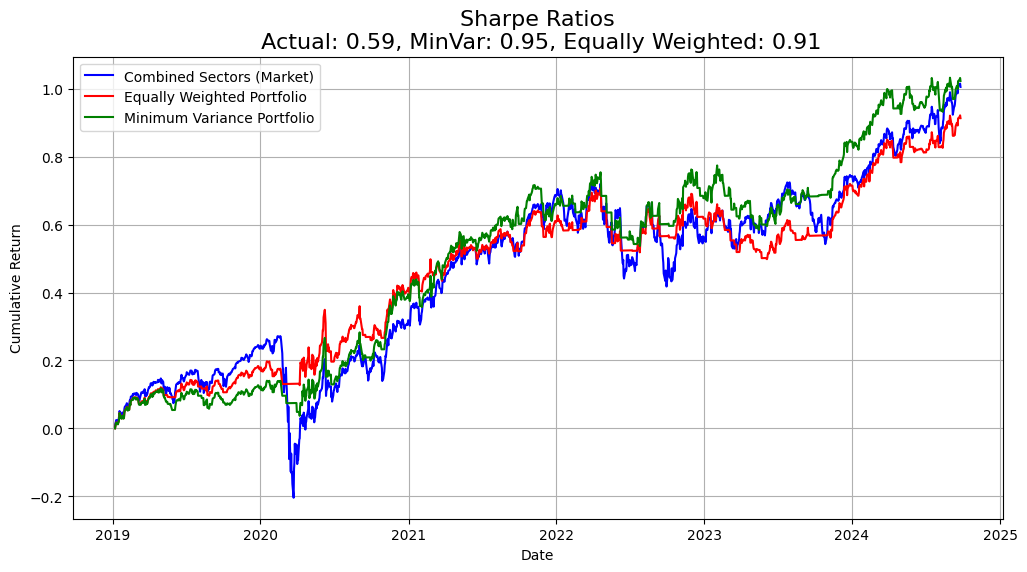

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(timeline_df, actual_sectors_cumulative, color="blue", label="Combined Sectors (Market)")
plt.plot(timeline_df, equallyweighted_sectors_cumulative, color="red", label="Equally Weighted Portfolio")
plt.plot(timeline_df, minvar_sectors_cumulative, color="green", label="Minimum Variance Portfolio")
plt.title(f"Sharpe Ratios\n Actual: {sharpe_ratio_actual:.2f}, MinVar: {sharpe_ratio_minvar:.2f}, Equally Weighted: {sharpe_ratio_equallyweighted:.2f}", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend() 
plt.grid(True)
plt.savefig('assetallocation.png')
plt.show()
